# Predict Future Sales

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta

In [2]:
from my_functions import merge_basic

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test)

In [6]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-08


In [7]:
def convert_silver(data):
    data_result = data.assign(TransactionType = np.where(data.item_cnt_day <= 0, 'SaleBack', 'Sale'))
    data_result['SaleDateMY'] = data_result['SaleDate'].dt.to_period('M').dt.to_timestamp()
    result = data_result.pivot_table(index = ['SaleDateMY', 'date_block_num', 'shop_id', 'item_id'], values = 'item_cnt_day',aggfunc = 'sum')
    result = result.reset_index()
    result = result.assign(shopitem = result.shop_id.astype('str') +'-'+ result.item_id.astype('str') )
    return result

In [8]:
wholedata_silver = convert_silver(train_merge)

In [9]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,1.0,2-33
1,2013-01-01,0,2,482,1.0,2-482
2,2013-01-01,0,2,491,1.0,2-491
3,2013-01-01,0,2,839,1.0,2-839
4,2013-01-01,0,2,1007,3.0,2-1007


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [11]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [12]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [13]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [14]:
date_val = datetime.datetime(2014, 10, 1)

In [15]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_cnt_day']].copy()

In [16]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_cnt_day,shopitem
0,2013-01-01,0,2,33,1.0,2-33
1,2013-01-01,0,2,482,1.0,2-482
2,2013-01-01,0,2,491,1.0,2-491
3,2013-01-01,0,2,839,1.0,2-839
4,2013-01-01,0,2,1007,3.0,2-1007


In [17]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [18]:
def completion_semi_gold(data):

    max_date = data.SaleDateMY.max()
    min_date = max_date - relativedelta(months=30)

    ### completing with 0 items with 0 in no dates
    result_data = data[(data.SaleDateMY >= min_date) & (data.SaleDateMY <= max_date)].pivot_table(index = ['shop_id', 'item_id','shopitem'], columns ='SaleDateMY', values = 'item_cnt_day', aggfunc = 'sum').reset_index().fillna(0)
    group_data = result_data.melt(id_vars=['shop_id', 'item_id','shopitem'], value_vars = result_data.columns[3:],  var_name='Date', value_name='Sale')

    ### get a map of the dates
    date_list =[group_data.Date.min()]
    date = group_data.Date.min()
    while date <= max_date:
        date = date_list[-1] + relativedelta(months=1)
        date_list.append(date)
    order_list = range(1,len(date_list)+1)
    date_map = pd.DataFrame({'Date':date_list, 'Order':order_list})
    data_maped = group_data.merge(date_map, on = 'Date', how = 'left')

    return data_maped

In [19]:
train_full = completion_semi_gold(train_window)

In [20]:
train_full.head()

,shop_id,item_id,shopitem,Date,Sale,Order
0,2,30,2-30,2013-01-01,0.0,1
1,2,31,2-31,2013-01-01,0.0,1
2,2,32,2-32,2013-01-01,0.0,1
3,2,33,2-33,2013-01-01,1.0,1
4,2,76,2-76,2013-01-01,0.0,1


In [21]:
train_full.sort_values('Sale', ascending = False)

,shop_id,item_id,shopitem,Date,Sale,Order
658884,31,20949,31-20949,2013-12-01,1305.0,12
653297,25,20949,25-20949,2013-12-01,1066.0,12
601679,31,20949,31-20949,2013-11-01,989.0,11
544474,31,20949,31-20949,2013-10-01,978.0,10
487269,31,20949,31-20949,2013-09-01,950.0,9
...,...,...,...,...,...,...
409882,12,6740,12-6740,2013-08-01,-2.0,8
581285,12,3734,12-3734,2013-11-01,-2.0,11
409538,12,1829,12-1829,2013-08-01,-2.0,8
56799,59,14931,59-14931,2013-01-01,-2.0,1


<b> scalling shopitem wise over L 1 differenciation per shopitem

In [22]:
def feature_silver(data):
    data = data.copy()
    ## feature of diff using one lag
    data['SaleL1M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
    data['SaleL2M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(2)
    data['SaleL3M'] = data.sort_values('Date').groupby(['shopitem'])['Sale'].shift(3)
    data_lagdiff = data.assign(L0M_L1M = data.Sale - data.SaleL1M)  ### This is new target ???? but yeaaaaaHHH
    data_lagdiff = data_lagdiff.assign(L1M_L2M = data_lagdiff.SaleL1M - data_lagdiff.SaleL2M) 
    data_lagdiff = data_lagdiff.assign(L2M_L3M = data_lagdiff.SaleL2M - data_lagdiff.SaleL3M) 
    data_lagdiff = data_lagdiff.drop(columns = ['SaleL2M','SaleL3M'])
    ### furhter lags in function of diff
    data_lagdiff['L11M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(11)
    data_lagdiff['L12M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(12)
    data_lagdiff['L13M'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['L1M_L2M'].shift(13)
    ## feature rolling average 3 months past
    #data_lagdiff['RollMeanL1'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).L1M_L2M.transform(lambda x: x.rolling(4, 1).mean())

    ## more laggs 
    #data_lagdiff['SaleRML1'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['RollMeanL1'].shift(12)

    ## Count no variation as dummy
    data_lagdiff['count0'] = np.where(data_lagdiff.L1M_L2M != 0,0,1)
    data_lagdiff['Roll0L1'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).count0.transform(lambda x: x.rolling(4, 1).sum())
    data_lagdiff['Roll0L1Mean'] = data_lagdiff.sort_values('Date').groupby(['shopitem']).Roll0L1.transform(lambda x: x.rolling(4, 1).mean())
    data_lagdiff['Completion0L1_1'] = np.where(data_lagdiff.Roll0L1Mean > 2.5,1,0)
    data_lagdiff['Completion0L1_0'] = np.where(data_lagdiff.Roll0L1Mean <= 2.5,1,0)
    data_lagdiff = data_lagdiff.drop(columns = ['count0'])
    
    ## addition lags
    data_lagdiff['Roll0L1L6'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0L1'].shift(6)
    data_lagdiff['Roll0L1L12'] = data_lagdiff.sort_values('Date').groupby(['shopitem'])['Roll0L1'].shift(12)
    
    
    data_result = data_lagdiff
    return data_result

In [23]:
train_feature = feature_silver(train_full)

In [24]:
## Examples to test
## train_feature[(train_feature.item_id == 30) & (train_feature.shop_id == 2)]
## train_feature[(train_feature.item_id == 20949) & (train_feature.shop_id == 31)]

In [25]:
df_test = train_feature[(train_feature.item_id == 30) & (train_feature.shop_id == 2)]

In [26]:
df_test.head()

,shop_id,item_id,shopitem,Date,Sale,Order,SaleL1M,L0M_L1M,L1M_L2M,L2M_L3M,L11M,L12M,L13M,Roll0L1,Roll0L1Mean,Completion0L1_1,Completion0L1_0,Roll0L1L6,Roll0L1L12
0,2,30,2-30,2013-01-01,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,0,1,NaN,NaN
57205,2,30,2-30,2013-02-01,0.0,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0,1,NaN,NaN
114410,2,30,2-30,2013-03-01,1.0,3,0.0,1.0,0.0,NaN,NaN,NaN,NaN,1,0.333333,0,1,NaN,NaN
171615,2,30,2-30,2013-04-01,0.0,4,1.0,-1.0,1.0,0.0,NaN,NaN,NaN,1,0.500000,0,1,NaN,NaN
228820,2,30,2-30,2013-05-01,0.0,5,0.0,0.0,-1.0,1.0,NaN,NaN,NaN,1,0.750000,0,1,NaN,NaN


In [27]:
def features_rows_train_silver(data, features, target, dates_back = 5):
    max_date = data.Date.max()
    min_date = max_date - relativedelta(days=dates_back)
    data_result = data[(data.Date >= min_date) & (data.Date <= max_date)][features + [target]]
    
    ### interaction terms
    
    data_result['interaction1'] = data_result['L1M_L2M'] * data_result['Completion0L1_1']
    data_result['interaction2'] = data_result['L1M_L2M'] * data_result['Completion0L1_0']
    data_result['interaction3'] = data_result['L2M_L3M'] * data_result['Completion0L1_1']
    data_result['interaction4'] = data_result['L2M_L3M'] * data_result['Completion0L1_0']
    
    ### Result
    features_new = list(data_result.columns)
    features_new.remove(target)
    data_result = data_result[features_new + [target]]
    
    return data_result

In [28]:
my_features = ['Date','Sale','SaleL1M','L1M_L2M','L2M_L3M','L11M','L12M','L13M','Roll0L1','Roll0L1Mean','Completion0L1_1','Completion0L1_0','Roll0L1L6','Roll0L1L12' ]
my_target = 'L0M_L1M'

In [29]:
train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, dates_back = 3)

In [30]:
train_selection.head()

,Date,Sale,SaleL1M,L1M_L2M,L2M_L3M,L11M,L12M,L13M,Roll0L1,Roll0L1Mean,Completion0L1_1,Completion0L1_0,Roll0L1L6,Roll0L1L12,interaction1,interaction2,interaction3,interaction4,L0M_L1M
1144100,2014-09-01,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,3,2.50,0,1,4.0,2.0,0.0,0.0,0.0,0.0,0.0
1144101,2014-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.25,0,1,4.0,3.0,0.0,0.0,0.0,0.0,0.0
1144102,2014-09-01,2.0,0.0,-1.0,1.0,0.0,0.0,0.0,2,1.75,0,1,2.0,4.0,-0.0,-1.0,0.0,1.0,2.0
1144103,2014-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,3.75,1,0,1.0,4.0,0.0,0.0,0.0,0.0,1.0
1144104,2014-09-01,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,2,2.75,1,0,4.0,4.0,0.0,0.0,-1.0,-0.0,0.0


In [31]:
todrop = ['Date','Sale','SaleL1M']
final_features = [x for x in my_features if x not in todrop]

In [32]:
def scaler(dataset, features, target, scaler=None):
    if scaler:
        df = dataset[features + [target]]
        df_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(df_scaled, columns = df.columns)
        return dataset_scaled
    
    else:
        df  = dataset[features + [target]]
        scaler = MinMaxScaler()
        scaler.fit(df)

        dataset_scaled = scaler.transform(df)
        dataset_scaled = pd.DataFrame(dataset_scaled, columns = df.columns)
        return dataset_scaled, scaler

In [33]:
train_scaled, my_scaler = scaler(train_selection, final_features, my_target, scaler=None)

In [34]:
train_scaled.head()

,L1M_L2M,L2M_L3M,L11M,L12M,L13M,Roll0L1,Roll0L1Mean,Completion0L1_1,Completion0L1_0,Roll0L1L6,Roll0L1L12,L0M_L1M
0,0.600939,0.619048,0.292903,0.538306,0.902153,0.75,0.6250,0.0,1.0,1.00,0.50,0.362319
1,0.600939,0.619048,0.292903,0.538306,0.904110,0.50,0.5625,0.0,1.0,1.00,0.75,0.362319
2,0.596244,0.622024,0.292903,0.538306,0.904110,0.50,0.4375,0.0,1.0,0.50,1.00,0.369565
3,0.600939,0.619048,0.292903,0.538306,0.904110,1.00,0.9375,1.0,0.0,0.25,1.00,0.365942
4,0.600939,0.616071,0.292903,0.538306,0.904110,0.50,0.6875,1.0,0.0,1.00,1.00,0.362319


### Basic ML modeling using linear regression with ridge regularization

In [35]:
X_train = train_scaled[final_features]
Y_train = train_scaled[my_target]

In [36]:
n_alphas = 100
alphas = np.logspace(-2, 3, n_alphas)

coefs = []
MSEs = []
for a in alphas:
    linearModel = Ridge(alpha=a, fit_intercept=True)
    linearModel.fit(X_train, Y_train)
    coefs.append(linearModel.coef_)
    Y_pred = linearModel.predict(X_train)
    MSE = mean_squared_error(Y_train,Y_pred)
    MSEs.append(MSE)

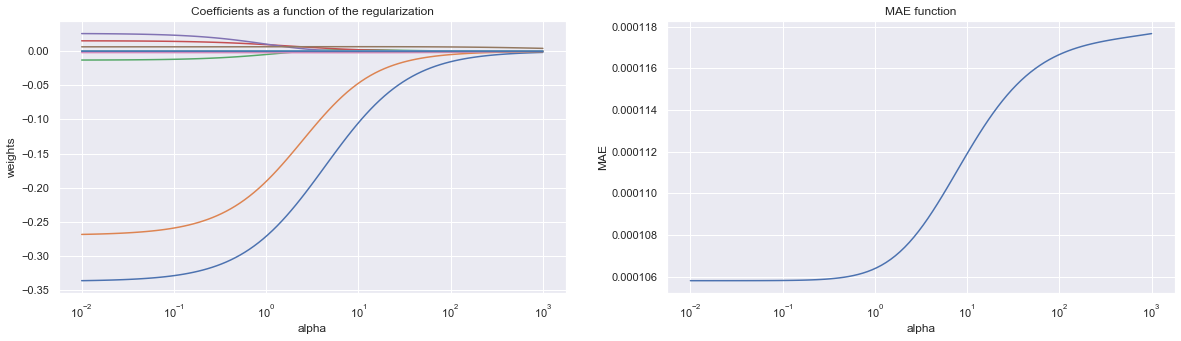

In [37]:
fig, ax = plt.subplots(1,2,figsize= (20,5))

ax[0].plot(alphas, coefs)
ax[0].set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('weights')
ax[0].set_title('Coefficients as a function of the regularization')
ax[0].axis('tight')

ax[1].plot(alphas, MSEs)
ax[1].set_xscale('log')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE function')
ax[1].axis('tight')

plt.show()

In [38]:
linearModel = Ridge(alpha=10**(-0.7), fit_intercept=True)
linearModel.fit(X_train, Y_train)

Ridge(alpha=0.19952623149688797)

In [39]:
Y_pred = linearModel.predict(X_train)

In [40]:
def inversed_scale(scaler, data, target_name, y_pred = np.array([])):
    data_new = data.copy()
    if y_pred.any():
        data_new[target_name] = y_pred
    
    unscaled_data = scaler.inverse_transform(data_new)
    unscaled_data = pd.DataFrame(unscaled_data, columns = data_new.columns)
    return unscaled_data

In [41]:
predicted_train = inversed_scale(scaler = my_scaler, data = train_scaled, target_name = my_target, y_pred = Y_pred)

In [42]:
def consolidation_prediction(data, prediction ):
    pdf_plot = data.copy()
    pdf_plot['PredictedVar'] = prediction
    pdf_plot['RealValueVar'] = pdf_plot.L0M_L1M
    pdf_plot = pdf_plot.assign(PredSale = pdf_plot.PredictedVar + pdf_plot.SaleL1M)
    pdf_plot = pdf_plot[['Date','Sale','PredSale', 'PredictedVar', 'RealValueVar', 'SaleL1M']]
    return pdf_plot

In [43]:
pdf_plot = consolidation_prediction(data = train_selection, prediction = predicted_train.L0M_L1M.values)

In [44]:
def plot_prediction(dfplot):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

    ax = sns.scatterplot(ax = axs[0], x="RealValueVar", y="PredictedVar", data=dfplot)
    ax = sns.scatterplot(ax = axs[1], x="Sale", y="PredSale", data=dfplot)

    x0, x1 = axs[0].get_xlim()
    y0, y1 = axs[0].get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    axs[0].plot(lims, lims, '-r')

    x0, x1 = axs[1].get_xlim()
    y0, y1 = axs[1].get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    axs[1].plot(lims, lims, '-r')

    axs[0].set(xlabel='Real Variation', ylabel='Predicted Variation', title='Scatter plot of variation predictions')

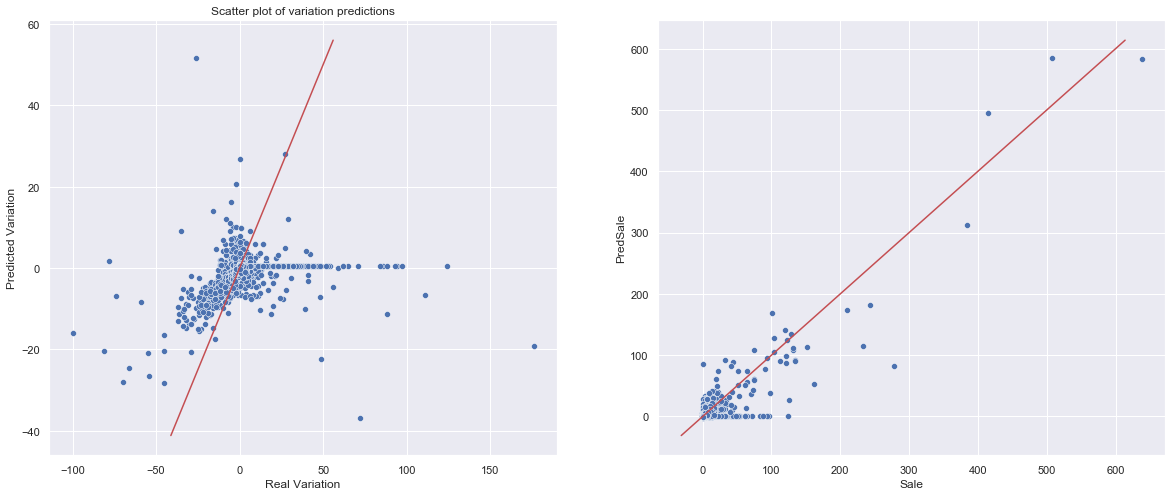

In [45]:
plot_prediction(pdf_plot)

<b> hold out validation

In [46]:
def preparing_to_predict(val_data, train_data):
    val_data_go = val_data.copy()
    val_data_go['date_block_num'] = np.nan
    val_data_go['shopitem'] = val_data_go['shop_id'].astype('str') + '-' + val_data_go['item_id'].astype('str')
    val_data_go = val_data_go[train_data.columns]
    result_data = pd.concat([train_data,val_data_go])
    return result_data

In [47]:
full_valandtrain = preparing_to_predict(val_data = val_window, train_data = train_window)
full_valandtrain = completion_semi_gold(full_valandtrain)

In [48]:
valandtrain_feature = feature_silver(full_valandtrain)

In [49]:
val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1)

In [50]:
val_scaled = scaler(val_selection, final_features, my_target, scaler=my_scaler)

In [51]:
X_val = val_scaled[final_features]

In [52]:
Y_pred = linearModel.predict(X_val)

In [53]:
predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)

In [54]:
my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)

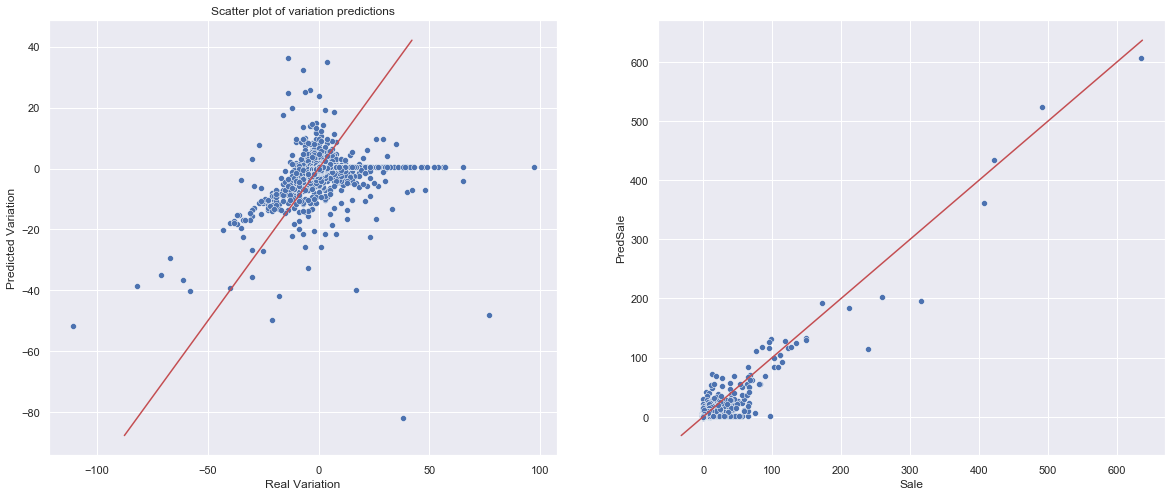

In [55]:
plot_prediction(my_lm_plot)

<b> completing validation

In [56]:
test_dates

[datetime.datetime(2014, 11, 1, 0, 0),
 datetime.datetime(2015, 4, 1, 0, 0),
 datetime.datetime(2015, 5, 1, 0, 0),
 datetime.datetime(2015, 6, 1, 0, 0),
 datetime.datetime(2015, 7, 1, 0, 0),
 datetime.datetime(2015, 8, 1, 0, 0),
 datetime.datetime(2015, 9, 1, 0, 0),
 datetime.datetime(2015, 10, 1, 0, 0)]

In [57]:
whole_test_data.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_cnt_day
290814,2014-11-01,22,2,486,2.0
290815,2014-11-01,22,2,491,1.0
290816,2014-11-01,22,2,806,1.0
290817,2014-11-01,22,2,1389,2.0
290818,2014-11-01,22,2,1485,1.0


In [58]:
def My_LM_prediction_on_test(dates_vector, whole_data):

    data_result = list()
    
    ### preparing whole data
    whole_full = completion_semi_gold(whole_data)
    whole_feature = feature_silver(whole_full)
    for datex in dates_vector:
        train_feature = whole_feature[whole_feature.Date < datex ].copy()
        valandtrain_feature = whole_feature[whole_feature.Date == datex ].copy()
        
        train_selection = features_rows_train_silver(data = train_feature, features = my_features, target = my_target, dates_back = 3)
        train_scaled, my_scaler = scaler(train_selection, final_features, my_target, scaler=None)
        
        ### ML train
        X_train = train_scaled[final_features]
        Y_train = train_scaled[my_target]
        linearModel = Ridge(alpha=10**(-0.7), fit_intercept=True)
        linearModel.fit(X_train, Y_train)
        
        ### Test data prepa
        val_selection = features_rows_train_silver(data = valandtrain_feature, features = my_features, target = my_target, dates_back = 1)
        val_scaled = scaler(val_selection, final_features, my_target, scaler=my_scaler)
        X_val = val_scaled[final_features]
        
        ## Prediction
        Y_pred = linearModel.predict(X_val)
        
        ## Saving Result
        predicted_val = inversed_scale(scaler = my_scaler, data = val_scaled, target_name = my_target, y_pred = Y_pred)
        my_lm_plot = consolidation_prediction(data = val_selection, prediction = predicted_val.L0M_L1M.values)
        data_result.append(my_lm_plot)
        print(f'the prediction over the {datex} data is done')
        
    return pd.concat(data_result)

In [59]:
myLM_test_results = My_LM_prediction_on_test(dates_vector = test_dates, whole_data = wholedata_silver)

the prediction over the 2014-11-01 00:00:00 data is done
the prediction over the 2015-04-01 00:00:00 data is done
the prediction over the 2015-05-01 00:00:00 data is done
the prediction over the 2015-06-01 00:00:00 data is done
the prediction over the 2015-07-01 00:00:00 data is done
the prediction over the 2015-08-01 00:00:00 data is done
the prediction over the 2015-09-01 00:00:00 data is done
the prediction over the 2015-10-01 00:00:00 data is done


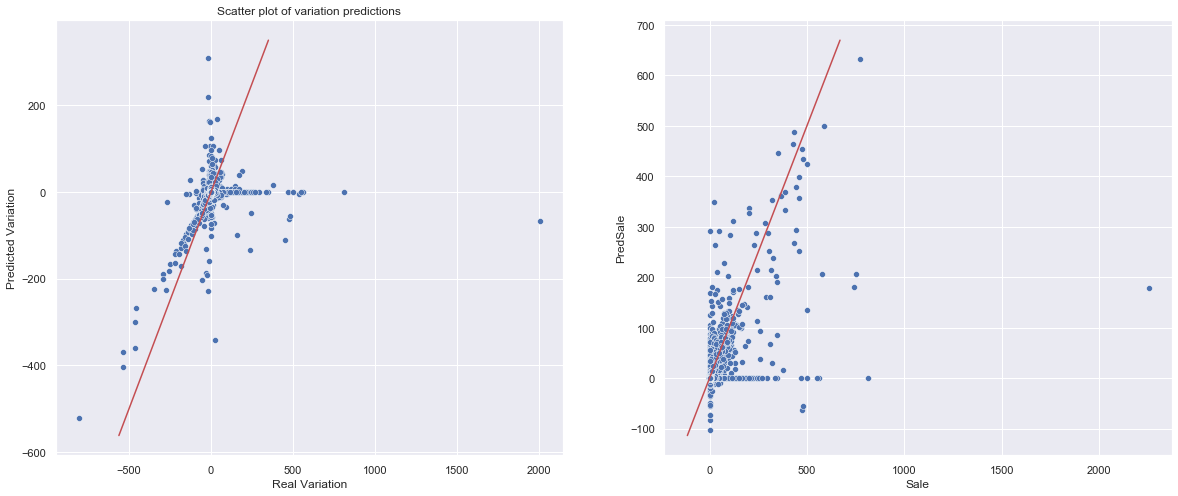

In [61]:
plot_prediction(myLM_test_results)

In [68]:
def plot_metrics(data):
    resultdict = {'Date':list(), 'RMSE':list()}
    for datex in data.Date.unique():
        df = data[data.Date == datex]
        rmse = (mean_squared_error(df.Sale, df.PredSale))**(1/2)
        resultdict['Date'].append(datex)
        resultdict['RMSE'].append(rmse)
    result = pd.DataFrame(resultdict)
    return result

In [70]:
rmse_results = plot_metrics(myLM_test_results)

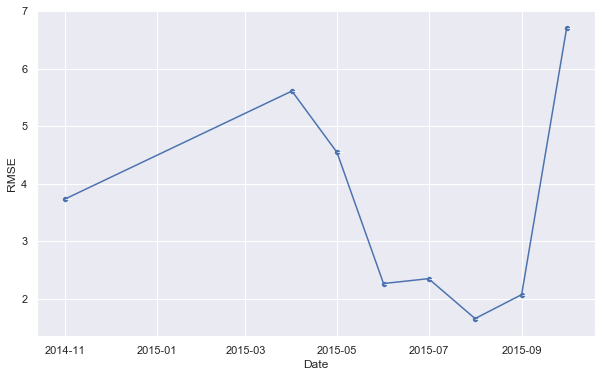

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,6), sharex=True)
ax = sns.lineplot(ax = axs , data = rmse_results, x="Date", y="RMSE", marker = True, )
ax = sns.scatterplot(ax = axs , data = rmse_results, x="Date", y="RMSE", s = 35 )

### Conclusions

* Easy way or process to work with features
* PREDICT VARIATIONS
* the target RMSE is less than 1
* keep that there are many 0
* the feature processing function consider all the dates
* the linear model experiment shows:
    + important presence of no variation
    + important presence of unexpected variations -> maybe means from other shops could help